# Example Notebook for plotting a fluxrope

In [1]:
%load_ext autoreload

%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.image import imread
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D

import datetime
from datetime import timedelta
import seaborn as sns
import pandas as pd
import os

import copy

import sunpy
from sunpy.time import parse_time
import sunpy.data.sample
import sunpy.map
from sunpy.net.helioviewer import HelioviewerClient
from sunpy.map import Map
from sunpy.coordinates import frames
import drms
import glymur
import zeep

import astropy
import astropy.units as u

import astropy
import astropy.constants as const
from astropy.coordinates import SkyCoord


import heliopy
import heliopy.spice as spice
import heliopy.data.spice as spicedata


import urllib
import pfsspy
import pfsspy
from pfsspy import coords
from pfsspy import tracing


import glob


import heliosat

import pickle

import py3dcore_h4c

#import astroquery

#import heliocats.plot as hp


import warnings
warnings.filterwarnings('ignore')

print(sns.__version__)

0.12.0


## simple speed calculation

In [2]:
#cor2 fov

r1=13*695000


#time in minutes from COR2 inner to outer
t1=90*60


speed=r1/t1

print('CME speed STEREO-A',speed)


#LASCO

CME speed STEREO-A 1673.148148148148


## ICMECAT

In [3]:
url='https://helioforecast.space/static/sync/icmecat/HELIO4CAST_ICMECAT_v21.csv'
ic=pd.read_csv(url)
ic=ic.drop(columns='Unnamed: 0') #drop an extra index column

iwin=np.where(ic.sc_insitu=='Wind')[0]
ista=np.where(ic.sc_insitu=='STEREO-A')[0]
istb=np.where(ic.sc_insitu=='STEREO-B')[0]

i1au=np.sort(np.hstack([iwin,ista,istb]))
print('ICMECAT events near 1 AU',len(i1au))

ICMECAT events near 1 AU 838


## py3DCORE

In [8]:
t_launch = datetime.datetime(2020, 12, 7, 18,0,0)



#2020 Dec 7: COR2 15 solar radii 18 UT


iparams_arr = np.array([[
    0,      # time offset
    30,    # l_1 (logitude) HEEQ
    0,#-20,    # l_2 (latitude)
    180,      # o (inclination, orientation)
    0.2,   # d_1au (frontal width at 1AU)
    3,   # delta (cross-section aspect ratio)
    15,      # r_0 (initialization distance in solar radii)
    1670,    # v_0 (initial velocty in)
    4,      # tau (magnetic field twist)
    1.0,      # b_s (magnetic field scaling parameter)
    25,     # b_1au (magnetic field strength at 1au)
    0.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

overwrite = {
    "cme_longitude": {
            "maximum": 31,
            "minimum": 29
        },
    "cme_latitude": {
            "maximum": 1,
            "minimum": -1
        },
    "cme_inclination" :{
            "maximum": 181,
            "minimum": 179
        },
    "cme_diameter_1au" :{
            "maximum": 0.25,
            "minimum": 0.15
        },
    "cme_aspect_ratio": {
            "maximum": 3.1,
            "minimum": 2.9
        },
    "cme_launch_radius": {
            "maximum": 16,
            "minimum": 14
        },
    "cme_launch_velocity": {
            "maximum": 1675,
            "minimum": 1665
        },
    "t_factor": {
            "maximum": 4.1,
            "minimum": 3.9
        },
    "magnetic_field_strength_1au": {
            "maximum": 26,
            "minimum": 24
        },
    "background_drag": {
            "maximum": 0.6,
            "minimum": 0.4
        },
    "background_velocity": {
            "maximum": 405,
            "minimum": 395
        },
}

n = 1#number of runs

#we initialize model for 1 run with default params

model_obj = py3dcore_h4c.ToroidalModel(t_launch, n, iparams=overwrite)

    Model Parameters
    ================
        For this specific model there are a total of 14 initial parameters which are as follows:
        0: t_i          time offset
        1: lon          longitude
        2: lat          latitude
        3: inc          inclination

        4: dia          cross section diameter at 1 AU
        5: delta        cross section aspect ratio

        6: r0           initial cme radius
        7: v0           initial cme velocity
        8: T            T factor (related to the twist)

        9: n_a          expansion rate
        10: n_b         magnetic field decay rate

        11: b           magnetic field strength at center at 1AU
        12: bg_d        solar wind background drag coefficient
        13: bg_v        solar wind background speed

        There are 4 state parameters which are as follows:
        0: v_t          current velocity
        1: rho_0        torus major radius
        2: rho_1        torus minor radius
        3: b_t          magnetic field strength at center

In [ ]:
# after the model has been initialized, we generate a set of random initial parameters according to the table above

model_obj.generator()
#model_obj.update_iparams(iparams_arr, seed=42)


#measurement times 
tm0 =  t_launch + datetime.timedelta(days=1)
tm1 =  t_launch + datetime.timedelta(days=3.5)
tm2 =  t_launch + datetime.timedelta(days=5.0)


#colors for 3dplots

c0 = 'mediumseagreen'
c1 = "xkcd:red"
c2 = "xkcd:blue"


#colors for components in plots
cbt = "xkcd:black"
cbx = "xkcd:magenta"
cby = "xkcd:orange"
cbz = "xkcd:azure"

############# define synthetic satellite positions - semi-circle at 1 AU, from -90 to +90 longitude

lonstart=-90
lonstep=5
lonend=90

lonend=lonend+lonstep
satpos=np.zeros(len(np.arange(lonstart,lonend,lonstep)),dtype=[('r',float),('lon', float),('lat', float)])
#convert to recarray
satpos = satpos.view(np.recarray)  

##### set position
satpos.r=1.0
satpos.lon=np.arange(lonstart,lonend,lonstep)
satpos.lat=0.0

#print(satpos.r, satpos.lon)    

#another satpos definition for a semi circle at 0.5 AU
satpos2=copy.deepcopy(satpos)
satpos2.r=0.5

## plot

In [5]:
#model_obj.iparams_arr[0][:]
model_obj.iparams_arr[0][8] = 50

ERROR


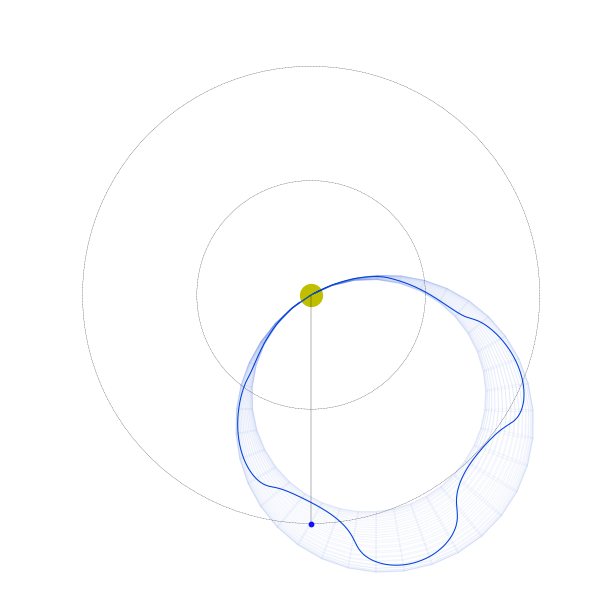

In [7]:
import fluxplot as fp

sns.set_context("talk")     

sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(1,figsize=(12,9),dpi=70)
ax = fig.add_subplot(111, projection='3d')

fp.plot_configure(ax, view_azim=0, view_elev=90, view_radius=0.8)

fp.plot_3dcore(ax, model_obj, tm1, color=c2)
fp.plot_3dcore_field(ax, model_obj, color=c2, step_size=0.005, lw=1.1, ls="-")
fp.plot_satellite(ax,satpos[18],color='blue',alpha=0.9)


ax.plot([0,1],[0,0],[0,0],ls='-',color='black',lw=0.3)

fp.plot_circle(ax,0.5)
fp.plot_circle(ax,1.0)

plt.tight_layout()


#plt.savefig('results/initial_test.pdf')
#plt.savefig('initial_test.png', dpi=100)